<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_2_yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP - Yelp data wrangling**
New York City restaurant

In [0]:
import pandas as pd
import requests

In [0]:
#client_id = 'NTXTygLQ8Y5baxwIGObaJA' 
#key = 'V28EIFx3cLv9o7-oZfNIrwi7dw3cmEW8DVWOU1HKdhDMjZhlhMvmGKe8C3P0Ohwxi31DbZrVlZSa2CdodvGKMddaopwFOv8TUdymcROofzsIfYZbj21IFCWNiB2JXHYx'

# get yelp api (https://www.yelp.com/developers)
# 

client_id = 'fl6Gc_WOT5VLrae0o6fc7w' 
key = 'kArR8ttjf4JdZDtC27-InwcgepdkWrtTcSfaHKwf_JMtQY0LvXgfaG3lmUA3F2oCCp-KUa-W8tPuVXdm8Abwj6N0m0YJniJHVa61rXEFMLuAM11d2IrYSV5NEYGJXHYx'

ENDPOINT = 'https://api.yelp.com/v3/businesses/search'

HEADERS = {'Authorization':'bearer {}'.format(key)}

PARAMETERS = {'term':'restaurant'or "food"  ,
             'limit':50,
             'radius':40000, # meter
              #'sort_by' :'review_count', 
             'location':"NYC"}

response = requests.get(url = ENDPOINT, params = PARAMETERS, headers = HEADERS)

read data (json) 

In [0]:
data = response.json()

In [115]:
data["businesses"][1]

{'alias': 'upstate-new-york-2',
 'categories': [{'alias': 'seafood', 'title': 'Seafood'},
  {'alias': 'wine_bars', 'title': 'Wine Bars'},
  {'alias': 'beerbar', 'title': 'Beer Bar'}],
 'coordinates': {'latitude': 40.7263139141197, 'longitude': -73.9864901976935},
 'display_phone': '(646) 791-5400',
 'distance': 2411.9187177986864,
 'id': 'ehUuSk5gPTCQmwS_ubgKRA',
 'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/RvnUVU7MF7DT0RzNL-EebQ/o.jpg',
 'is_closed': False,
 'location': {'address1': '95 1st Ave',
  'address2': '',
  'address3': '',
  'city': 'New York',
  'country': 'US',
  'display_address': ['95 1st Ave', 'New York, NY 10003'],
  'state': 'NY',
  'zip_code': '10003'},
 'name': 'Upstate',
 'phone': '+16467915400',
 'price': '$$',
 'rating': 4.5,
 'review_count': 1681,
 'transactions': ['restaurant_reservation'],
 'url': 'https://www.yelp.com/biz/upstate-new-york-2?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=fl

In [112]:
data["businesses"][10]['categories'][2]['title']# info of the business

'American (New)'

In [33]:
data["businesses"][0]['id'] # parse id for review (with highest review count)

'ETgJqJHV7BW6pIr9Ox74sA'

read review of this businesses of the highest review count

In [0]:
ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/44SY464xDHbvOcjDzRbKkQ/reviews'   # id/reviews  
response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)

In [163]:
response_reviews.json()['reviews'][0]#['user']['profile_url']

{'id': 'ZNXhzuRQCRAuRlZp1qEhYA',
 'rating': 5,
 'text': "OMG!!! I don't think this place needs another review but their ramen is out of this world.\n\nI ordered the akamaru modern, with their suggested toppings. It...",
 'time_created': '2019-03-13 11:20:34',
 'url': 'https://www.yelp.com/biz/ippudo-ny-new-york-7?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=ZNXhzuRQCRAuRlZp1qEhYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w',
 'user': {'id': 'jDxo59C8cG_2K9QinPggNQ',
  'image_url': 'https://s3-media2.fl.yelpcdn.com/photo/Q_BkcvM91p8y0Vru3UZ1Og/o.jpg',
  'name': 'Stephen N.',
  'profile_url': 'https://www.yelp.com/user_details?userid=jDxo59C8cG_2K9QinPggNQ'}}

In [24]:
len(response_reviews.json())

3

In [25]:
response_reviews.text

'{"reviews": [{"id": "ZNXhzuRQCRAuRlZp1qEhYA", "url": "https://www.yelp.com/biz/ippudo-ny-new-york-7?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=ZNXhzuRQCRAuRlZp1qEhYA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w", "text": "OMG!!! I don\'t think this place needs another review but their ramen is out of this world.\\n\\nI ordered the akamaru modern, with their suggested toppings. It...", "rating": 5, "time_created": "2019-03-13 11:20:34", "user": {"id": "jDxo59C8cG_2K9QinPggNQ", "profile_url": "https://www.yelp.com/user_details?userid=jDxo59C8cG_2K9QinPggNQ", "image_url": "https://s3-media2.fl.yelpcdn.com/photo/Q_BkcvM91p8y0Vru3UZ1Og/o.jpg", "name": "Stephen N."}}, {"id": "Gv5yXSp5y8J-8Vf1BpV4ug", "url": "https://www.yelp.com/biz/ippudo-ny-new-york-7?adjust_creative=fl6Gc_WOT5VLrae0o6fc7w&hrid=Gv5yXSp5y8J-8Vf1BpV4ug&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_reviews&utm_source=fl6Gc_WOT5VLrae0o6fc7w", "text": "Came here for lunch

Next, we can make a list of the businesses with their id, rating, and price

In [0]:
# list of id in businesses with rating
list_buss = []
#i = 0s
for item in data['businesses']:
  #print(i)
  #i+= 1
  try:
    list_buss.append([item['id'], item['rating'], item['price'],item['review_count']])#, \
                    #  item['categories'][0]['alias'], item['categories'][1]['alias'],item['categories'][2]['alias'],\
                    #  item['categories'][0]['title'], item['categories'][1]['title'],item['categories'][1]['title']])
  except:
    #list_buss.append([item['id'], item['rating'], None, None, None, None, None, None, None, None])
    pass
  #print(item['id'])
#list_buss

In [138]:
len(list_of_ids)

50

In [140]:
# convert to pandas format
#list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count', 'alitas1', 'alitas2', 'alitas3','title1',\
#'title2','title3'])
list_buss = pd.DataFrame(list_buss, columns = ['id','rating','price', 'count'])

list_buss.head()

,id,rating,price,count
0,ETgJqJHV7BW6pIr9Ox74sA,4.5,$$,2395
1,ehUuSk5gPTCQmwS_ubgKRA,4.5,$$,1681
2,CwOAKJdX8AMz5iAoA-ZEuA,4.0,$$,428
3,tiSw-6DIm3-mMORyEIOVyg,4.5,$$,1746
4,jjJc_CrkB2HodEinB6cWww,4.0,$$,4032


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdeb95a2f60>,
      dtype=object)

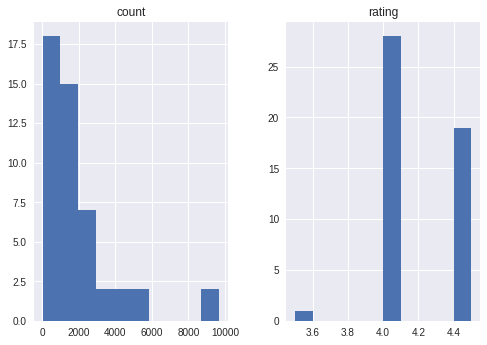

In [141]:
list_buss.hist()

In [143]:
list_buss.groupby('price').count()

,id,rating,count
price,,,
$,5,5,5
$$,38,38,38
$$$,5,5,5


In [147]:
high_rating = list_buss[list_buss['rating']>=4.0]
high_rating.head()

,id,rating,price,count
0,ETgJqJHV7BW6pIr9Ox74sA,4.5,$$,2395
1,ehUuSk5gPTCQmwS_ubgKRA,4.5,$$,1681
2,CwOAKJdX8AMz5iAoA-ZEuA,4.0,$$,428
3,tiSw-6DIm3-mMORyEIOVyg,4.5,$$,1746
4,jjJc_CrkB2HodEinB6cWww,4.0,$$,4032


In [0]:
# colect review
List_reiew_all = []
for i in range(len(high_rating)):
  #print(i)
  try:
    ENDPOINT_reviews = 'https://api.yelp.com/v3/businesses/'+ high_rating['id'][i] +'/reviews'
    response_reviews = requests.get(url = ENDPOINT_reviews, headers = HEADERS)
    for ii in range(2):
      x = response_reviews.json()['reviews'][ii]['text']
      List_reiew_all.append(x)
  except:
    pass

In [151]:
List_reiew_all_pd = pd.DataFrame(List_reiew_all, columns =['review'])
#len(List_reiew_all_pd)
List_reiew_all_pd.head()

,review
0,Five star experience. I came here back in Dece...
1,My fiancé and I came here for brunch this past...
2,I came here a good 3 times and if you're an oy...
3,Read in a review/article somewhere to come and...
4,Hey I just had the calamari - it was one of th...
